In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


import warnings
warnings.filterwarnings('ignore')

# 1. Dataset 확인

In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/data/3-8/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/data/3-8/test.csv')

In [7]:
df_train.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619
1,1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387
2,2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772
3,3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71,666
4,4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77,14453


* 예측하려는 target label은 price입니다.

* 변수 설명 
    * carat : 무게
    * cut : 절단 품질 -> Fair < Good < Very Good < Premium < Ideal
    * color : 색 -> D가 가장 좋고 J가 가장 나쁘다
    * clarity : 선명도 - 내포물과 흠집이 없는 것을 의미(FL = 무결함 > IF > VVS1 > VVS2 > VS1 > VS2> SI1 > SI2 > I1 > I2 > I3 = 레벨 3 내포물)
    * depth : 높이를 평균 직경으로 나눈 값?
    * table : 평균 직경의 백분율로 표시된다.
    * x : 길이(mm)
    * y : 너비(mm)
    * z : 높이(mm)
    * price : 가격


In [8]:
df_train.shape

(193573, 11)

In [9]:
df_test.shape

(129050, 10)

In [10]:
df_train.describe()

,id,carat,depth,table,x,y,z,price
count,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000
mean,96786.000000,0.790688,61.820574,57.227675,5.715312,5.720094,3.534246,3969.155414
std,55879.856166,0.462688,1.081704,1.918844,1.109422,1.102333,0.688922,4034.374138
min,0.000000,0.200000,52.100000,49.000000,0.000000,0.000000,0.000000,326.000000
25%,48393.000000,0.400000,61.300000,56.000000,4.700000,4.710000,2.900000,951.000000
50%,96786.000000,0.700000,61.900000,57.000000,5.700000,5.720000,3.530000,2401.000000
75%,145179.000000,1.030000,62.400000,58.000000,6.510000,6.510000,4.030000,5408.000000
max,193572.000000,3.500000,71.600000,79.000000,9.650000,10.010000,31.300000,18818.000000


In [11]:
df_test.describe()

,id,carat,depth,table,x,y,z
count,129050.000000,129050.000000,129050.000000,129050.000000,129050.000000,129050.000000,129050.000000
mean,258097.500000,0.789256,61.820522,57.239608,5.711767,5.716336,3.531802
std,37253.670457,0.462502,1.080249,1.918908,1.109666,1.102485,0.690749
min,193573.000000,0.200000,53.200000,51.000000,0.000000,0.000000,0.000000
25%,225835.250000,0.400000,61.300000,56.000000,4.700000,4.710000,2.900000
50%,258097.500000,0.700000,61.900000,57.000000,5.700000,5.720000,3.530000
75%,290359.750000,1.030000,62.400000,58.000000,6.510000,6.510000,4.030000
max,322622.000000,4.500000,70.600000,70.000000,10.140000,10.140000,31.800000


In [12]:
df_train.isnull().sum()

id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

* null값은 없다!!

## 1.1 Null data check

* null 값이 없으므로 pass

## 1.2 Target label 확인

In [26]:
print('제일 비싼 가격: {:.1f}'.format(df_train['price'].max()))
print('제일 싼 가격 : {:.1f}'.format(df_train['price'].min()))
print('평균 가격: {:.1f}'.format(df_train['price'].mean()))

제일 비싼 가격: 18818.0
제일 싼 가격 : 326.0
평균 가격: 3969.2


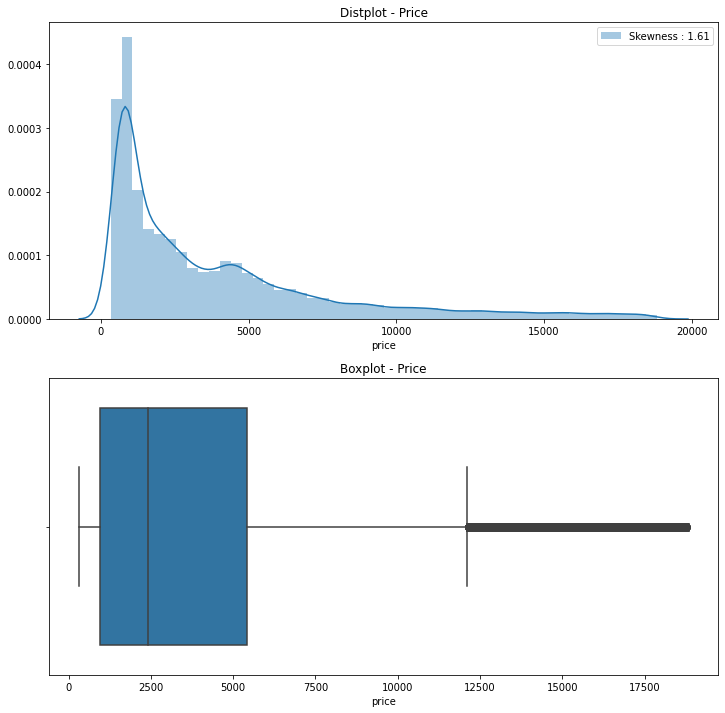

In [22]:
f, ax = plt.subplots(2, 1, figsize = (12, 12))

g = sns.distplot(df_train['price'], label = 'Skewness : {:.2f}'.format(df_train['price'].skew()), ax = ax[0])
g = g.legend(loc='best')
ax[0].set_title('Distplot - Price')
ax[0].set_ylabel('')

sns.boxplot(df_train['price'], ax = ax[1])
ax[1].set_title('Boxplot - Price')

plt.show()

* pirce는 대부분 1000 ~ 5000 사이에 분포해 있다.
* 왜도는 1.61이다.
* 그래프가 왼쪽으로 치우쳐져 있는 것으로 보아 평균보다 가격이 싼 보석이 많다.

# 2. Exploratory data analysis

* 연속형 : carcat, depth, table, x, y, z, price
* 이산형 : cut, color, clarity

In [35]:
continuous = ['carcat', 'depth', 'table', 'x', 'y', 'z', 'price']
discrete = ['cut', 'color', 'clarity']

* 무게는 무거울수록 가격이 비쌀 것 같다.
* 절단품질은 좋을수록 가격이 비쌀 것 같다.
* 색은 크게 영향을 줄 것 같지 않지만 좋은 색일수록 가격이 비쌀 것 같다.
* 선명도는 좋을수록 가격이 비쌀 것 같다.
* 높이와 테이블은 크게 영향을 줄 수 있는 label이 아닌 것 같다.
* x,y.z 각각 보다는 3개의 값이 골골루 높으면 가격이 비쌀 것 같다.

## 2.1 carat

* 1캐럿은 0.2g

* 같은 종류의 보석이라면 무게가 무거울수록 가격이 비쌀 것이다. 
* 종류가 다르다면 무게만 가지고는 가격을 예측하긴 어려울 것 같다.

In [30]:
print('제일 무거운 무게: {:.2f} carat'.format(df_train['carat'].max()))
print('제일 가벼운 무게 : {:.2f} carat'.format(df_train['carat'].min()))
print('평균 무게: {:.2f} carat'.format(df_train['carat'].mean()))

제일 무거운 무게: 3.50 carat
제일 가벼운 무게 : 0.20 carat
평균 무게: 0.79 carat


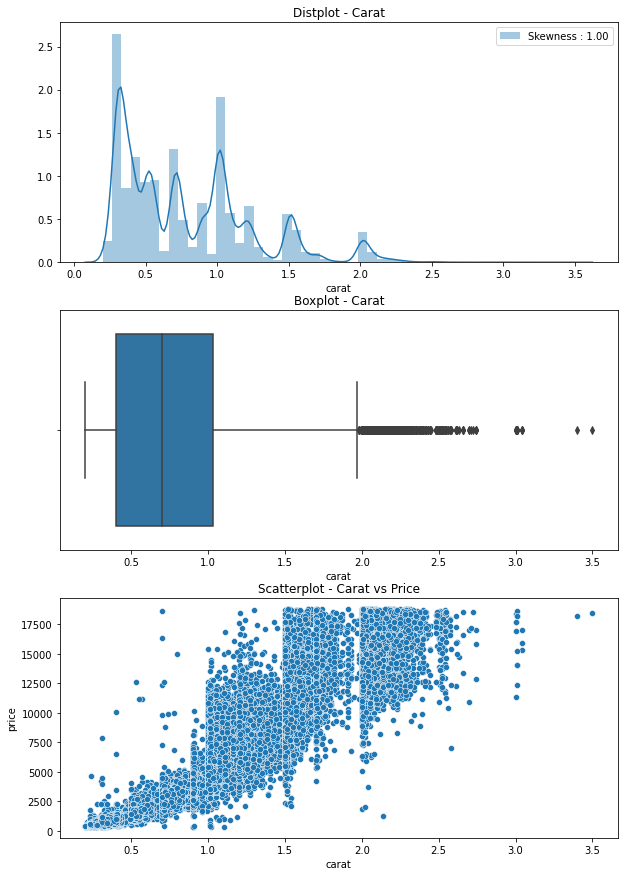

In [33]:
f, ax = plt.subplots(3, 1, figsize = (10, 15))

g = sns.distplot(df_train['carat'], label = 'Skewness : {:.2f}'.format(df_train['carat'].skew()), ax = ax[0])
g = g.legend(loc='best')
ax[0].set_title('Distplot - Carat')
ax[0].set_ylabel('')

sns.boxplot(df_train['carat'], ax = ax[1])
ax[1].set_title('Boxplot - Carat')

sns.scatterplot(data = df_train, x = 'carat', y = 'price', ax = ax[2])
ax[2].set_title('Scatterplot - Carat vs Price')

plt.show()

* 캐럿과 가격은 어느정도 상관관계가 있는것으로 보인다.
* 캐럿이 3이상인 값은 거의 없고 특히 3.5부근에 있는 데이터는 2개정도이다.
* 무게가 더 무겁더라도 가격이 싼 데이터가 존재한다.
* 약 0.3 ~ 1.1캐럿 사이에 분포가 많다.
* 유의미한 변수로 작용할 것 같다.

## 2.2 cut

* 절단 품질이 좋을수록 가격이 비쌀 것 같다.

In [4]:
df_train['cut'].value_counts()

Ideal        92454
Premium      49910
Very Good    37566
Good         11622
Fair          2021
Name: cut, dtype: int64

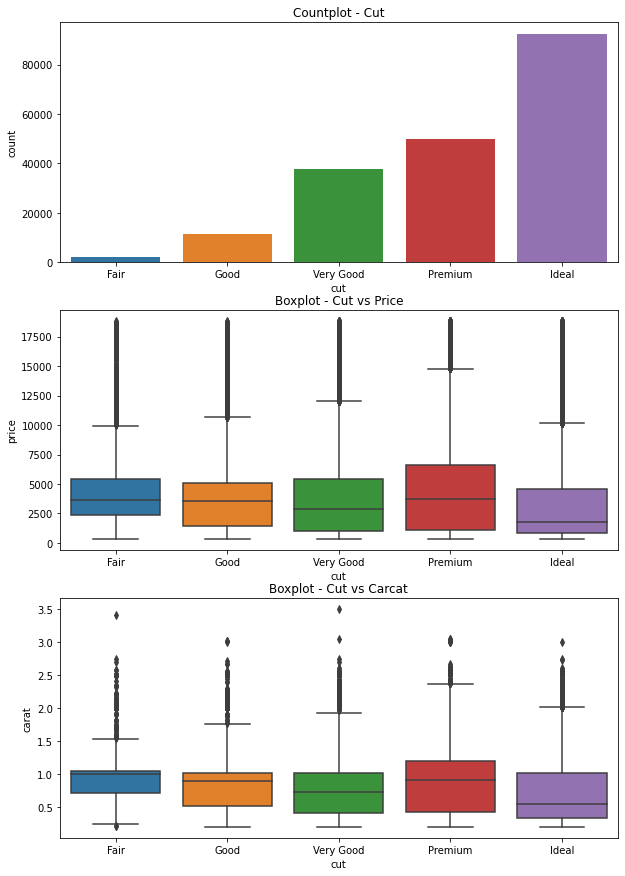

In [18]:
f, ax = plt.subplots(3, 1, figsize = (10, 15))

sns.countplot(data = df_train, x = 'cut', order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], ax = ax[0])
ax[0].set_title('Countplot - Cut')

sns.boxplot(data = df_train, x = 'cut', y ='price', order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], ax = ax[1])
ax[1].set_title('Boxplot - Cut vs Price')

sns.boxplot(data = df_train, x = 'cut', y ='carat', order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], ax = ax[2])
ax[2].set_title('Boxplot - Cut vs Carcat')

plt.show()

* 품질이 좋을수록 데이터 수도 많다.
* 가격 최대값이 가장 높은 품질은 premium이다. 예상외로 ideal 보석의 가격이 그렇게 높지 않다.
* 무게도 Premium이 가장 높다. 무게는 절단 품질이 좋은 보석이 대체로 무게도 무거운 것 같다.
* 유의미한 변수로 작용할지는 잘 모르겠다.

## 2.3 color

* 좋은 색을 가질수록 보석(D에 가까울 수록)이 비싼 가격일 것 같다.

In [19]:
df_train['color'].value_counts()

G    44391
E    35869
F    34258
H    30799
D    24286
I    17514
J     6456
Name: color, dtype: int64

* 좋은 색 순서 : D > E > F > G > H > I > J 

In [21]:
order = df_train['color'].value_counts().sort_index().index

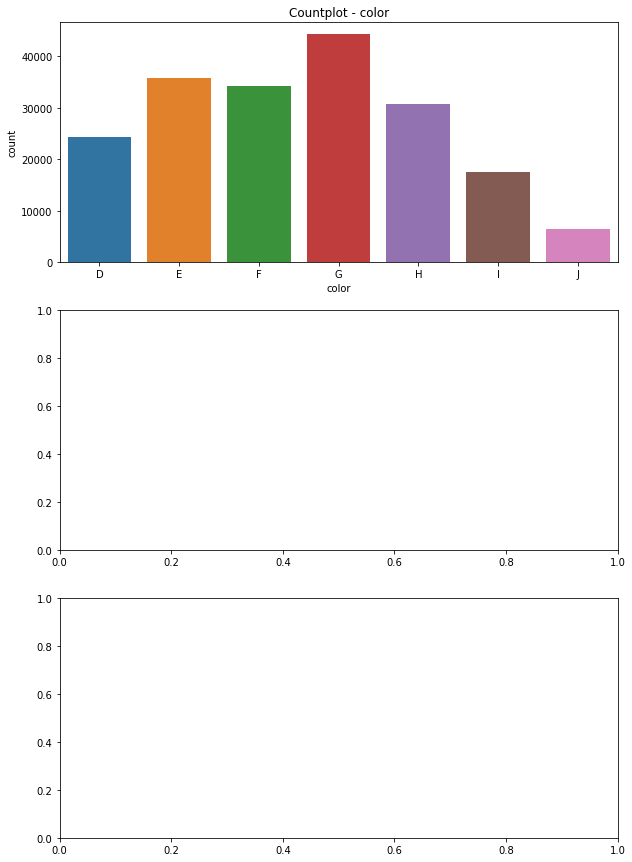

In [34]:
f, ax = plt.subplots(3, 1, figsize = (10, 15))

sns.countplot(data = df_train, x = 'color', order = order, ax = ax[0])
ax[0].set_title('Countplot - color')

plt.show()

<AxesSubplot:xlabel='color', ylabel='price'>

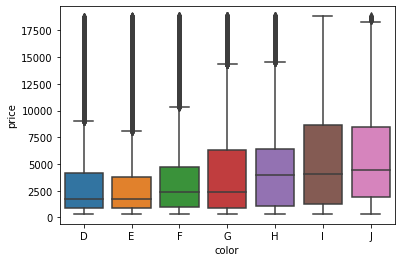

In [24]:
sns.boxplot(data = df_train, x = 'color', y = 'price', order = order)

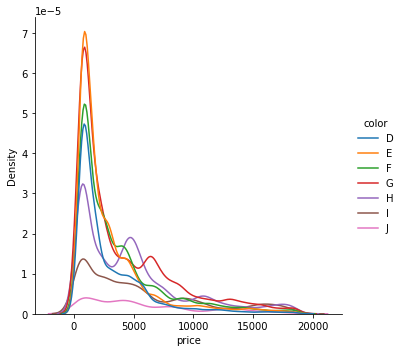

In [33]:
sns.displot(data = df_train, x = 'price', hue = 'color', kind = 'kde', hue_order = order)